# Train the StarNet Model

This notebook takes you through the steps of how to train a StarNet Model
- Required Python packages: `numpy h5py keras`
- Required data files: training_data.h5, mean_and_std.npy

Note: We use tensorflow for the keras backend.

In [130]:
import numpy as np
import h5py
import random
import keras
from keras.models import Model
from keras.layers import Input, Dense, InputLayer, Flatten, Reshape
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.optimizers import Adam
import tensorflow as tf
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.utils import HDF5Matrix
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc


#Loading the data

#RVSFlux
normrvs = 'norm_rvsflux.h5'
readnorm = h5py.File(normrvs, 'r')
print(readnorm.keys())
norm_flux = readnorm.get('normrvs')
norm_flux = np.array(norm_flux)
readnorm.close()

#LogTeff
modparam = 'modparam_feh0.h5' #model parameters includes log g and teff
readfile = h5py.File(modparam, 'r')
print(readfile.keys())
teff = readfile.get('teff')
teff = np.array(teff)
logg = readfile.get('logg')
logg = np.array(logg)
print(teff)
readfile.close()


print('The shapes of features and labels:', np.shape(norm_flux), np.shape(teff))










<KeysViewHDF5 ['normrvs']>
<KeysViewHDF5 ['logg', 'teff']>
[ 3500.  3500.  3500.  3500.  3500.  3500.  3500.  3500.  3500.  3500.
  3500.  3750.  3750.  3750.  3750.  3750.  3750.  3750.  3750.  3750.
  3750.  3750.  4000.  4000.  4000.  4000.  4000.  4000.  4000.  4000.
  4000.  4000.  4000.  4250.  4250.  4250.  4250.  4250.  4250.  4250.
  4250.  4250.  4250.  4250.  4500.  4500.  4500.  4500.  4500.  4500.
  4500.  4500.  4500.  4500.  4500.  4750.  4750.  4750.  4750.  4750.
  4750.  4750.  4750.  4750.  4750.  4750.  5000.  5000.  5000.  5000.
  5000.  5000.  5000.  5000.  5000.  5000.  5000.  5250.  5250.  5250.
  5250.  5250.  5250.  5250.  5250.  5250.  5250.  5250.  5500.  5500.
  5500.  5500.  5500.  5500.  5500.  5500.  5500.  5500.  5500.  5750.
  5750.  5750.  5750.  5750.  5750.  5750.  5750.  5750.  5750.  5750.
  6000.  6000.  6000.  6000.  6000.  6000.  6000.  6000.  6000.  6000.
  6000.  6250.  6250.  6250.  6250.  6250.  6250.  6250.  6250.  6250.
  6500.  6500.  65

In [131]:

#features
num_tot = len(teff)
print('total number of input stars =', num_tot)
plim = 0.8
ran_frac = np.random.uniform(0,1,num_tot)
#print('ranfrac=' , ran_frac)
x_train = norm_flux[ran_frac < plim, :]
print('number of training data=', len(x_train[:,0]))
x_cv= norm_flux[ran_frac >= plim, :] #test set we left for the application



#output label which is the logteff and log g
y_teff_train = teff[ran_frac< plim]
y_teff_cv = teff[ran_frac >= plim] #test set

y_logg_train = logg[ran_frac< plim]
y_logg_cv = logg[ran_frac >= plim] #test set


id = np.linspace(0, len(x_train[:, 0])-1, len(x_train[:, 0]))
#plt.plot(id, y_train)
#plt.show()


total number of input stars = 415
number of training data= 326


** Normalization **

Write a function to normalize the output labels. Each label will be normalized to have approximately have a mean of zero and unit variance.

NOTE: This is necessary to put output labels on a similar scale in order for the model to train properly, this process is reversed in the test stage to give the output labels their proper units

In [132]:
def normalize(labels, mean_label, std_label):
    # Normalize labels
    return (labels-mean_label) / std_label

def denormalize(labels, mean_label, std_label):
    return (((labels)*(std_label)) + mean_label)






In [133]:
#normalize the y labels, the log teff and log g 

mean_teff = np.mean(y_teff_train)
std_teff = np.std(y_teff_train)

mean_logg = np.mean(y_logg_train)
std_logg = np.std(y_logg_train)

#output label which is the logteff and log g
y_teff_train = normalize(y_teff_train, mean_teff, std_teff)
y_teff_cv = normalize(y_teff_cv, mean_teff, std_teff)

y_logg_train = normalize(y_logg_train, mean_logg, std_logg)
y_logg_cv = normalize(y_logg_cv, mean_logg, std_logg)


print('type of data ', type(y_teff_train),type(y_teff_cv), type(y_logg_train), type(y_logg_cv) )

type of data  <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


**Build the StarNet model architecture**

The StarNet architecture is built with:
- input layer
- 2 convolutional layers
- 1 maxpooling layer followed by flattening for the fully connected layer
- 2 fully connected layers
- output layer

First, let's define some model variables.

In [134]:
# activation function used following every layer except for the output layers
activation = 'relu'

# model weight initializer
initializer = 'he_normal'

# number of filters used in the convolutional layers
#num_filters = [4,16]
num_filters = [8,32]
#num_filters = [8,16]

# length of the filters in the convolutional layers
#filter_length = 8
#filter_length = 16
filter_length = 8

# length of the maxpooling window 
pool_length = 4

# number of nodes in each of the hidden fully connected layers
num_hidden = [256,128]
#num_hidden = [24,12]

# number of spectra fed into model at once during training
batch_size = 64

# maximum number of interations for model training
#max_epochs = 200
#max_epochs = 100
#max_epochs = 150 
#max_epochs = 350
#max_epochs = 225
#max_epochs = 180
#max_epochs = 450
#max_epochs = 300
max_epochs = 200


# initial learning rate for optimization algorithm
lr = 0.000003 #handled by Adam
    
# exponential decay rate for the 1st moment estimates for optimization algorithm
beta_1 = 0.9

# exponential decay rate for the 2nd moment estimates for optimization algorithm
beta_2 = 0.999

# a small constant for numerical stability for optimization algorithm
optimizer_epsilon = 1e-08

In [135]:
num_fluxes=len(x_train[0,:]) 
print('number of training fluxes=', num_fluxes)

num_labels= 2
print('number of training teff=', num_labels)

#ilam = np.linspace(0, num_fluxes-1, num_fluxes)
#plt.plot(ilam, x_train[329, :])
#plt.plot()

#iy = np.linspace(0, len(y_train)-1, len(y_train))
#plt.plot(iy, y_train)
#plt.plot()

number of training fluxes= 1134
number of training teff= 2


In [136]:

# Input spectra
input_spec = Input(shape=(num_fluxes,), name='starnet_input_x')

# Reshape spectra for CNN layers
cur_in = Reshape((num_fluxes, 1))(input_spec)

# CNN layers
cur_in = Conv1D(kernel_initializer=initializer, activation=activation, 
                padding="same", filters=num_filters[0], kernel_size=filter_length)(cur_in) #first CNN layer
cur_in = Conv1D(kernel_initializer=initializer, activation=activation,
                padding="same", filters=num_filters[1], kernel_size=filter_length)(cur_in) #2nd CNN layer

# Max pooling layer
cur_in = MaxPooling1D(pool_size=pool_length)(cur_in)

# Flatten the current input for the fully-connected layers
cur_in = Flatten()(cur_in)

# Fully-connected layers
cur_in = Dense(units=num_hidden[0], kernel_initializer=initializer, 
               activation=activation)(cur_in)
cur_in = Dense(units=num_hidden[1], kernel_initializer=initializer, 
               activation=activation)(cur_in)

# Output nodes
output_label = Dense(units=num_labels, activation="linear", 
                     input_dim=num_hidden[1], name='starnet_output_y')(cur_in)

model = Model(input_spec, output_label, name='StarNet')

**More model techniques**
* The `Adam` optimizer is the gradient descent algorithm used for minimizing the loss function
* `EarlyStopping` uses the cross-validation set to test the model following every iteration and stops the training if the cv loss does not decrease by `min_delta` after `patience` iterations
* `ReduceLROnPlateau` is a form of learning rate decay where the learning rate is decreased by a factor of `factor` if the training loss does not decrease by `epsilon` after `patience` iterations unless the learning rate has reached `min_lr`

In [137]:
# Default loss function parameters
early_stopping_min_delta = 0.0007
early_stopping_patience = 4
reduce_lr_factor = 0.5
reuce_lr_epsilon = 0.0000009
reduce_lr_patience = 2
reduce_lr_min = 0.00008

# loss function to minimize
loss_function = 'mean_squared_error'

# compute mean absolute deviation
metrics = ['mae', 'mse']
#metrics = ['mae']

In [138]:
#optimizer = Adam(lr=lr, beta_1=beta_1, beta_2=beta_2, epsilon=optimizer_epsilon, decay=0.0)
optimizer = Adam(lr=0.0005 )

early_stopping = EarlyStopping(monitor='val_loss', min_delta=early_stopping_min_delta, 
                                       patience=early_stopping_patience, verbose=2, mode='min')

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, epsilon=reuce_lr_epsilon, 
                                  patience=reduce_lr_patience, min_lr=reduce_lr_min, mode='min', verbose=2)

**Compile model**

In [139]:
model.compile(optimizer=optimizer, loss=loss_function, metrics=metrics)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
starnet_input_x (InputLayer) (None, 1134)              0         
_________________________________________________________________
reshape_7 (Reshape)          (None, 1134, 1)           0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 1134, 8)           72        
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 1134, 32)          2080      
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 283, 32)           0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 9056)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)               2318592   
__________

**Train model**

In [140]:
y_train_stack = np.column_stack((y_teff_train, y_logg_train))
y_cv_stack = np.column_stack ((y_teff_cv, y_logg_cv))

print('shape of the cv teff and logg=', np.shape(y_cv_stack))
print(' shape of y teff and logg=', np.shape(y_train_stack))
#history = model.fit(x=[x_RVStrain, x_BPtrain, x_RPtrain], y=y_train_stack,
          #validation_split=0.2, epochs=max_epochs, verbose=1, shuffle='batch')
        
history = model.fit(x=x_train, y= y_train_stack, 
                    validation_data=(x_cv, y_cv_stack),
          epochs=max_epochs, verbose=1, shuffle='batch')

shape of the cv teff and logg= (89, 2)
 shape of y teff and logg= (326, 2)
Train on 326 samples, validate on 89 samples
Epoch 1/200
326/326 [==============================] - 1s 4ms/step - loss: 3.8800 - mean_absolute_error: 1.4932 - mean_squared_error: 3.8800 - val_loss: 1.5013 - val_mean_absolute_error: 1.0145 - val_mean_squared_error: 1.5013
Epoch 2/200
326/326 [==============================] - 0s 995us/step - loss: 1.4322 - mean_absolute_error: 0.9783 - mean_squared_error: 1.4322 - val_loss: 1.5677 - val_mean_absolute_error: 0.9557 - val_mean_squared_error: 1.5677
Epoch 3/200
326/326 [==============================] - 0s 994us/step - loss: 1.6731 - mean_absolute_error: 1.0770 - mean_squared_error: 1.6731 - val_loss: 1.0209 - val_mean_absolute_error: 0.7666 - val_mean_squared_error: 1.0209
Epoch 4/200
326/326 [==============================] - 0s 1ms/step - loss: 1.0186 - mean_absolute_error: 0.7771 - mean_squared_error: 1.0186 - val_loss: 0.8748 - val_mean_absolute_error: 0.7545 -

326/326 [==============================] - 0s 1ms/step - loss: 0.1379 - mean_absolute_error: 0.2750 - mean_squared_error: 0.1379 - val_loss: 0.1392 - val_mean_absolute_error: 0.2785 - val_mean_squared_error: 0.1392
Epoch 37/200
326/326 [==============================] - 1s 2ms/step - loss: 0.1464 - mean_absolute_error: 0.2826 - mean_squared_error: 0.1464 - val_loss: 0.1433 - val_mean_absolute_error: 0.2691 - val_mean_squared_error: 0.1433
Epoch 38/200
326/326 [==============================] - 0s 1ms/step - loss: 0.1360 - mean_absolute_error: 0.2697 - mean_squared_error: 0.1360 - val_loss: 0.1291 - val_mean_absolute_error: 0.2621 - val_mean_squared_error: 0.1291
Epoch 39/200
326/326 [==============================] - 0s 1ms/step - loss: 0.1089 - mean_absolute_error: 0.2432 - mean_squared_error: 0.1089 - val_loss: 0.1334 - val_mean_absolute_error: 0.2490 - val_mean_squared_error: 0.1334
Epoch 40/200
326/326 [==============================] - 0s 1ms/step - loss: 0.0970 - mean_absolute_er

Epoch 72/200
326/326 [==============================] - 1s 2ms/step - loss: 0.0474 - mean_absolute_error: 0.1553 - mean_squared_error: 0.0474 - val_loss: 0.0932 - val_mean_absolute_error: 0.2083 - val_mean_squared_error: 0.0932
Epoch 73/200
326/326 [==============================] - 0s 995us/step - loss: 0.0377 - mean_absolute_error: 0.1415 - mean_squared_error: 0.0377 - val_loss: 0.0912 - val_mean_absolute_error: 0.2088 - val_mean_squared_error: 0.0912
Epoch 74/200
326/326 [==============================] - 0s 997us/step - loss: 0.0395 - mean_absolute_error: 0.1497 - mean_squared_error: 0.0395 - val_loss: 0.0929 - val_mean_absolute_error: 0.2143 - val_mean_squared_error: 0.0929
Epoch 75/200
326/326 [==============================] - 0s 1ms/step - loss: 0.0449 - mean_absolute_error: 0.1569 - mean_squared_error: 0.0449 - val_loss: 0.1053 - val_mean_absolute_error: 0.2162 - val_mean_squared_error: 0.1053
Epoch 76/200
326/326 [==============================] - 0s 1ms/step - loss: 0.0546 -

Epoch 108/200
326/326 [==============================] - 0s 1ms/step - loss: 0.0180 - mean_absolute_error: 0.0975 - mean_squared_error: 0.0180 - val_loss: 0.0793 - val_mean_absolute_error: 0.1676 - val_mean_squared_error: 0.0793
Epoch 109/200
326/326 [==============================] - 0s 1ms/step - loss: 0.0259 - mean_absolute_error: 0.1202 - mean_squared_error: 0.0259 - val_loss: 0.0743 - val_mean_absolute_error: 0.1743 - val_mean_squared_error: 0.0743
Epoch 110/200
326/326 [==============================] - 0s 1ms/step - loss: 0.0182 - mean_absolute_error: 0.0983 - mean_squared_error: 0.0182 - val_loss: 0.0749 - val_mean_absolute_error: 0.1735 - val_mean_squared_error: 0.0749
Epoch 111/200
326/326 [==============================] - 0s 1ms/step - loss: 0.0241 - mean_absolute_error: 0.1135 - mean_squared_error: 0.0241 - val_loss: 0.0739 - val_mean_absolute_error: 0.1826 - val_mean_squared_error: 0.0739
Epoch 112/200
326/326 [==============================] - 1s 2ms/step - loss: 0.0241 

Epoch 144/200
326/326 [==============================] - 1s 2ms/step - loss: 0.0098 - mean_absolute_error: 0.0725 - mean_squared_error: 0.0098 - val_loss: 0.0638 - val_mean_absolute_error: 0.1520 - val_mean_squared_error: 0.0638
Epoch 145/200
326/326 [==============================] - 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0675 - mean_squared_error: 0.0091 - val_loss: 0.0650 - val_mean_absolute_error: 0.1565 - val_mean_squared_error: 0.0650
Epoch 146/200
326/326 [==============================] - 0s 1ms/step - loss: 0.0093 - mean_absolute_error: 0.0687 - mean_squared_error: 0.0093 - val_loss: 0.0641 - val_mean_absolute_error: 0.1560 - val_mean_squared_error: 0.0641
Epoch 147/200
326/326 [==============================] - 0s 1ms/step - loss: 0.0095 - mean_absolute_error: 0.0726 - mean_squared_error: 0.0095 - val_loss: 0.0679 - val_mean_absolute_error: 0.1509 - val_mean_squared_error: 0.0679
Epoch 148/200
326/326 [==============================] - 0s 1ms/step - loss: 0.0097 

Epoch 180/200
326/326 [==============================] - 0s 1ms/step - loss: 0.0056 - mean_absolute_error: 0.0551 - mean_squared_error: 0.0056 - val_loss: 0.0629 - val_mean_absolute_error: 0.1512 - val_mean_squared_error: 0.0629
Epoch 181/200
326/326 [==============================] - 0s 1ms/step - loss: 0.0057 - mean_absolute_error: 0.0552 - mean_squared_error: 0.0057 - val_loss: 0.0624 - val_mean_absolute_error: 0.1489 - val_mean_squared_error: 0.0624
Epoch 182/200
326/326 [==============================] - 0s 2ms/step - loss: 0.0059 - mean_absolute_error: 0.0578 - mean_squared_error: 0.0059 - val_loss: 0.0661 - val_mean_absolute_error: 0.1468 - val_mean_squared_error: 0.0661
Epoch 183/200
326/326 [==============================] - 0s 1ms/step - loss: 0.0061 - mean_absolute_error: 0.0581 - mean_squared_error: 0.0061 - val_loss: 0.0663 - val_mean_absolute_error: 0.1570 - val_mean_squared_error: 0.0663
Epoch 184/200
326/326 [==============================] - 0s 1ms/step - loss: 0.0066 

In [141]:
hist = pd.DataFrame(history.history)
hist['epoch']= history.epoch
hist.tail()

,val_loss,val_mean_absolute_error,val_mean_squared_error,loss,mean_absolute_error,mean_squared_error,epoch
195,0.063079,0.148167,0.063079,0.004350,0.049276,0.004350,195
196,0.063262,0.147575,0.063262,0.004572,0.050234,0.004572,196
197,0.063564,0.152073,0.063564,0.004196,0.047855,0.004196,197
198,0.064213,0.151451,0.064213,0.004113,0.047317,0.004113,198
199,0.063523,0.149258,0.063523,0.003897,0.045883,0.003897,199


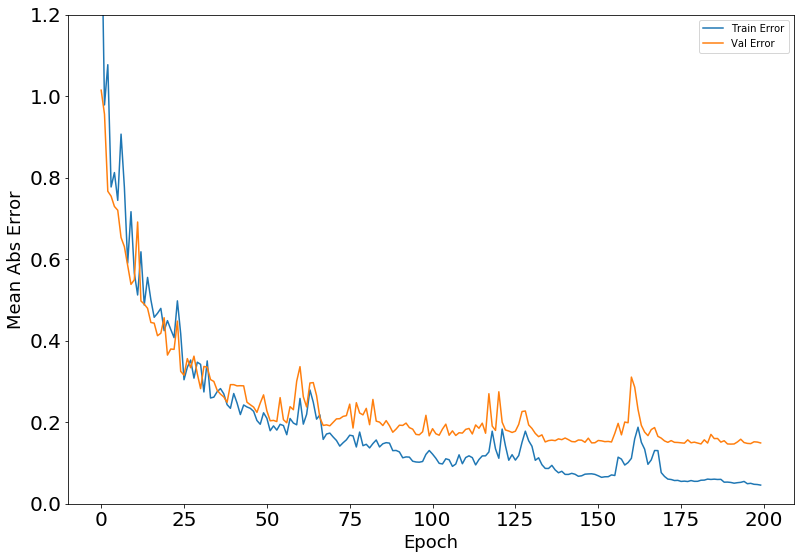

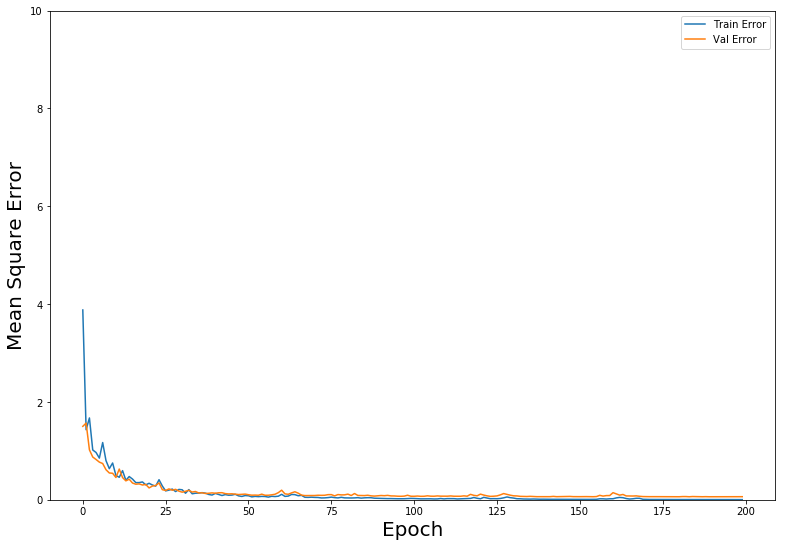

In [142]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
    
  plt.figure(figsize=(13,9))
  #plt.figure()
  plt.xlabel('Epoch', fontsize= 18)
  plt.ylabel('Mean Abs Error', fontsize= 18)
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,1.2])
  plt.tick_params(labelsize=20)
  plt.legend()
  

  plt.figure(figsize=(13,9))
  #plt.figure()
  plt.xlabel('Epoch', fontsize = 20)
  plt.ylabel('Mean Square Error', fontsize= 20)
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,10])
  plt.legend()
  plt.show()


plot_history(history)

**Save model**

(326, 2)
(326,)
(326,)


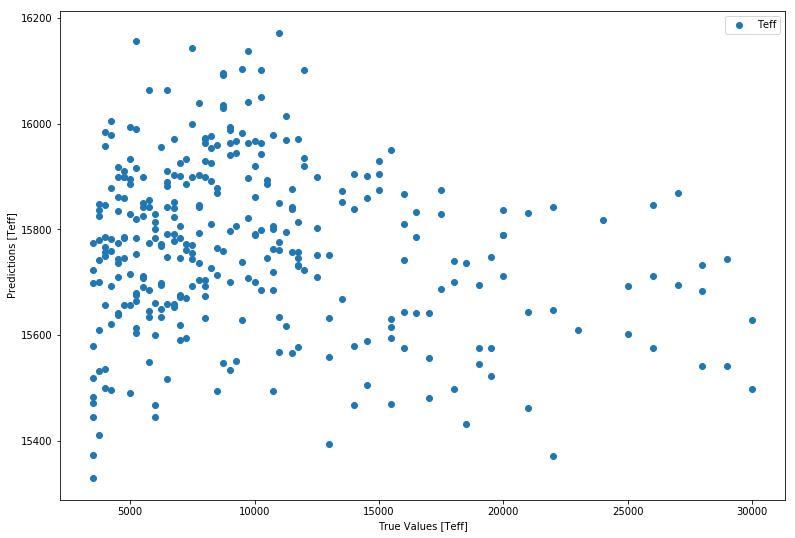

In [143]:

test_predictions = model.predict(x_train)
print(np.shape(test_predictions))
print(np.shape(y_train_stack[:,0]))
print(np.shape(y_train_stack[:,1]))
plt.figure(figsize=(13,9))
plt.scatter((denormalize(y_train_stack[:,0], mean_teff, std_teff )), denormalize(x_train[:,0], mean_teff, std_teff), label= 'Teff')
#plt.scatter((denormalize(y_train_stack[:,1], mean_logg, std_logg)), denormalize(test_predictions[:,1], mean_logg, std_teff), label= 'Log(g)')
plt.xlabel('True Values [Teff]')
plt.ylabel('Predictions [Teff]')
#plt.axis('equal')
#plt.axis('square')

#plt.xlim([0,plt.xlim()[1]])
#plt.ylim([0,plt.ylim()[1]])
#_ = plt.plot([0, 30000], [0, 30000])
plt.legend()
plt.show()
#print('test predictions=', test_predictions)

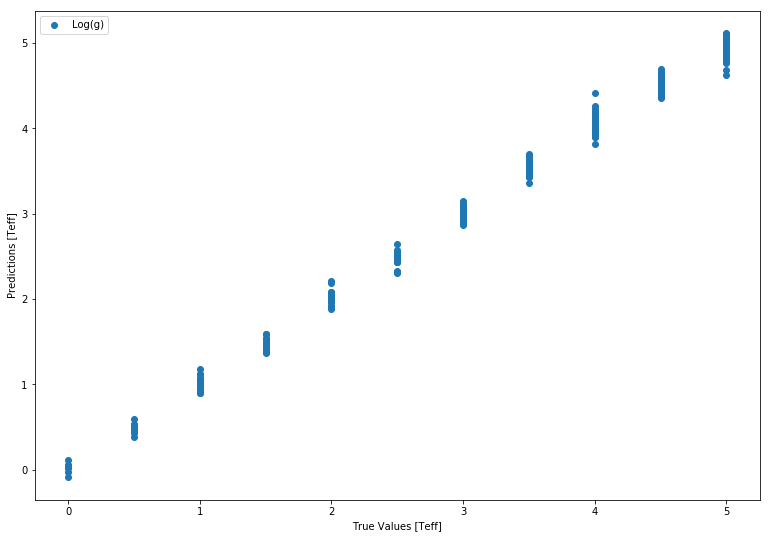

In [144]:
plt.figure(figsize=(13,9))
plt.scatter((denormalize(y_train_stack[:,1], mean_logg, std_logg)), denormalize(test_predictions[:,1], mean_logg, std_logg), label= 'Log(g)')
plt.xlabel('True Values [Teff]')
plt.ylabel('Predictions [Teff]')
plt.legend()
plt.show()



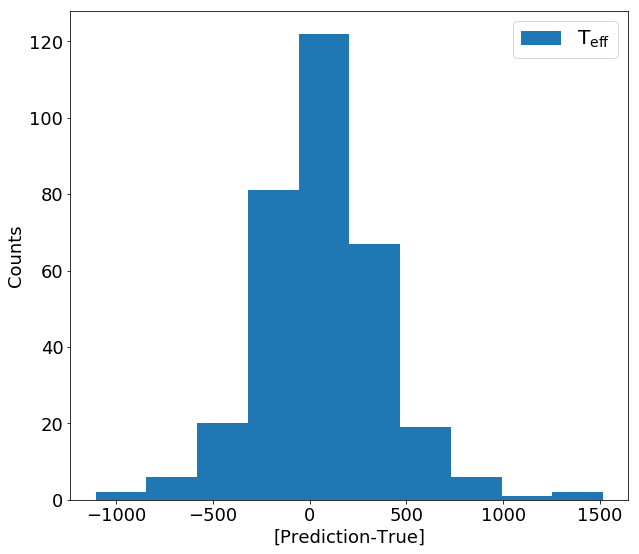

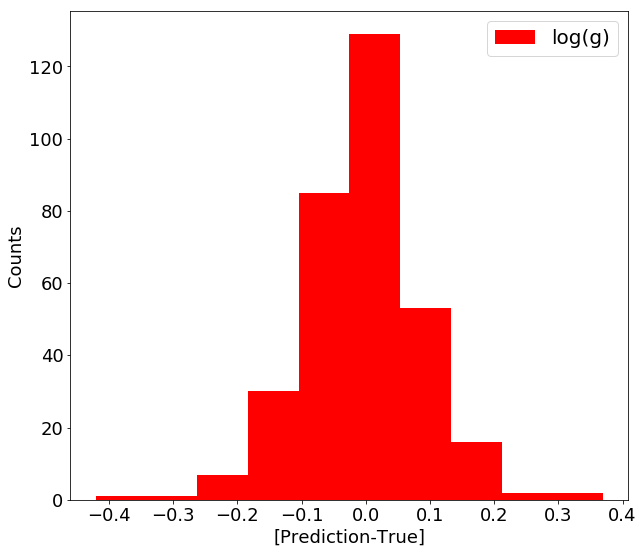

In [145]:
#Making the histogram of denormalized training set 

plt.figure(figsize=(10,9))
data_teff=np.subtract(denormalize(y_train_stack[:,0], mean_teff, std_teff), denormalize(test_predictions[:,0], mean_teff, std_teff)) 
data_logg=np.subtract(denormalize(y_train_stack[:,1], mean_logg, std_logg), denormalize(test_predictions[:,1], mean_logg, std_logg)) 

counts_teff, bins_teff = np.histogram(data_teff)
counts_logg, bins_logg = np.histogram(data_logg)

#histogram for LogTeff
plt.hist(bins_teff[:-1], bins_teff, weights=counts_teff, label= r'$\rm T_{\rm eff}$')
plt.tick_params(labelsize=18) 
plt.xlabel(r'[Prediction-True]', fontsize=18)
plt.ylabel('Counts', fontsize=18)
plt.legend(fontsize=20)
plt.show()

#histogram for Log(g)
plt.figure(figsize=(10,9))
plt.hist(bins_logg[:-1], bins_logg, weights=counts_logg, label= 'log(g)', color='red')
plt.tick_params(labelsize=18) 
plt.xlabel(r'[Prediction-True]', fontsize=18)
plt.ylabel('Counts', fontsize=18)
plt.legend(fontsize=20)
plt.show()




#print('standard deviation', len(z))
#print(len(z[teff<5000]))
#print(len(z))

# Training Data Set

In [148]:
# getting deviation in Teff bins
nbin = 10
teffbin_edges=np.array([ 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000])



# pred vs. true
# unnormalised values
teff_pred = denormalize(test_predictions[:,0], mean_teff, std_teff)
teff_true = denormalize(y_train_stack[:,0], mean_teff, std_teff) #teff values are created by read_spectra1_updatedwavelength from the nsc Allende Prieto spectra library
teff_diff = teff_pred-teff_true

# compute mean and std in Teff bins
teff_diff_mean = np.zeros(nbin) 
teff_diff_std = np.zeros(nbin)
teffbin_mean = np.zeros(nbin)

for i in range(nbin): #iterations(0,1,2,3,4)
    if i==0:
        indx = np.where(teff_true<teffbin_edges[i]) #index of teff_true where teff true< 5000 since teff has all values of teff in each library
        #print(indx)
    elif i==nbin-1: #if i= 5-1= 4
        indx = np.where(teff_true>teffbin_edges[i-1]) #index of true_teff>20000
    else: #if i=1,2,3
        indx = np.where((teff_true>teffbin_edges[i-1]) & (teff_true<teffbin_edges[i]))
        #if i=1, teff_true>(teffbin_edges[1-1=0]= 5000) & teff_true<teffbin_edges[1]= 10000, so 5000<teff<10000
        #if i=2, teff_true>(teffbin_edges[2-1=1]=10000) & teff_true<teffbin_edges[2]= 15000, so 10000<teff<15000
        #if i=3, teff_true> (teffbin_edges[3-1=2]= 15000) & teff_true<teffbin_edges[3]= 20000 so 15000<teff<20000
    teffbin_mean[i] = np.mean(teff_true[indx]) #calculating the mean values of teff_true from assigning its index in the for loop
    teff_diff_mean[i] = np.mean(teff_diff[indx]) #calculating the mean values of teff_diff from its index 
    teff_diff_std[i] = np.std(teff_diff[indx]) #calculating the std values of teff-diff from its index
    
print('mean of bin teff_true=', teffbin_mean)
print('mean of teff_diff=', teff_diff_mean)
print('std of teff_diff=', teff_diff_std)
print('length of teff_diff=', len(teff_diff))

####################################################################################################################
print('==========================================================================================================')
# getting deviation in Teff bins
nbin = 5
loggbin_edges=np.array([ 1, 2, 3, 4, 5])

# pred vs. true
# unnormalised values
logg_pred = denormalize(test_predictions[:,1], mean_logg, std_logg)
logg_true = denormalize(y_train_stack[:,1], mean_logg, std_logg) #teff values are created by read_spectra1_updatedwavelength from the nsc Allende Prieto spectra library
logg_diff = logg_pred-logg_true

# compute mean and std in Teff bins
logg_diff_mean = np.zeros(nbin) 
logg_diff_std = np.zeros(nbin)
loggbin_mean = np.zeros(nbin)

for i in range(nbin): #iterations(0,1,2,3,4)
    if i==0:
        indx = np.where(logg_true<loggbin_edges[i]) #index of teff_true where teff true< 5000 since teff has all values of teff in each library
        #print(indx)
    elif i==nbin-1: #if i= 5-1= 4
        indx = np.where(logg_true>loggbin_edges[i-1]) #index of true_teff>20000
    else: #if i=1,2,3
        indx = np.where((logg_true>loggbin_edges[i-1]) & (logg_true<loggbin_edges[i]))

    loggbin_mean[i] = np.mean(logg_true[indx]) #calculating the mean values of teff_true from assigning its index in the for loop
    logg_diff_mean[i] = np.mean(logg_diff[indx]) #calculating the mean values of teff_diff from its index 
    logg_diff_std[i] = np.std(logg_diff[indx]) #calculating the std values of teff-diff from its index
    
print('mean of bin logg_true=', loggbin_mean)
print('mean of logg_diff=', logg_diff_mean)
print('std of logg_diff=', logg_diff_std)
print('length of logg_diff=', len(logg_diff))








IndexError: index 8 is out of bounds for axis 0 with size 8

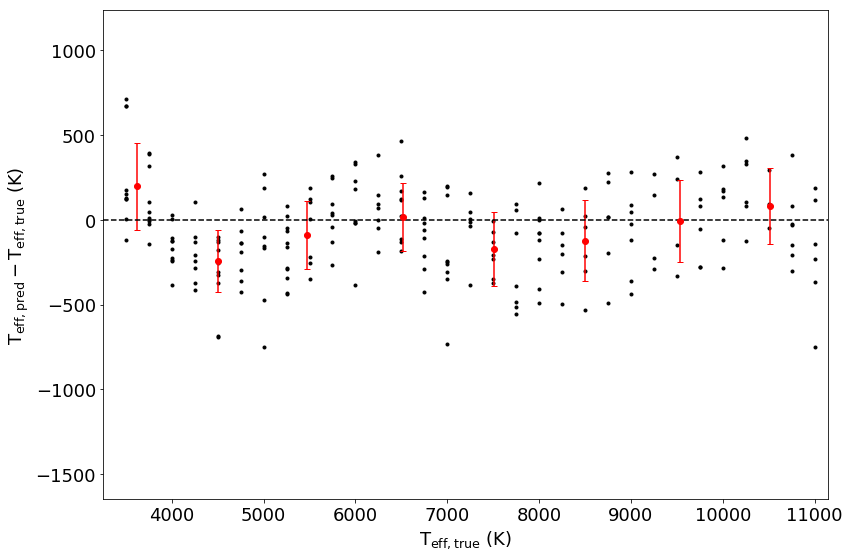

In [149]:
# plot of logteff
plt.figure(figsize=(13,9))
# plot the difference
plt.scatter(teff_true, teff_diff ,c='k', marker='.')
#plt.plot(teff_true, teff_diff,'o', markersize=1, c='k')

# plot mean (symbol) and scatter with error bars
plt.errorbar(teffbin_mean, teff_diff_mean, yerr=teff_diff_std, fmt='o', c='r',capsize=3) #plotting the teff bin mean in x-axis and teff_diff in y-axis

# increase the x,y tick label size
plt.tick_params(labelsize=18) 

# set x, y label. 
plt.xlabel(r"$T_{\rm eff,true}$ (K)", fontsize=18)
plt.ylabel(r"$T_{\rm eff,pred}-T_{\rm eff,true}$ (K)", fontsize=18)

# set x, y lim plot range
xlim=np.array([3250, 11150])
ylim=np.array([-800, 1000])
plt.xlim(xlim[0],xlim[1]) #plotting the xlim
#plt.ylim(ylim[0],ylim[1])

# set x, y label. 
plt.xlabel(r"$\rm T_{\rm eff,true}$ (K)", fontsize=18)
plt.ylabel(r"$\rm T_{\rm eff,pred}-\rm T_{\rm eff,true}$ (K)", fontsize=18)

# draw y=0 line
xline = np.linspace(xlim[0],xlim[1], 2)
yline = np.zeros_like(xline)
plt.plot(xline,yline,linestyle='--',c='k')






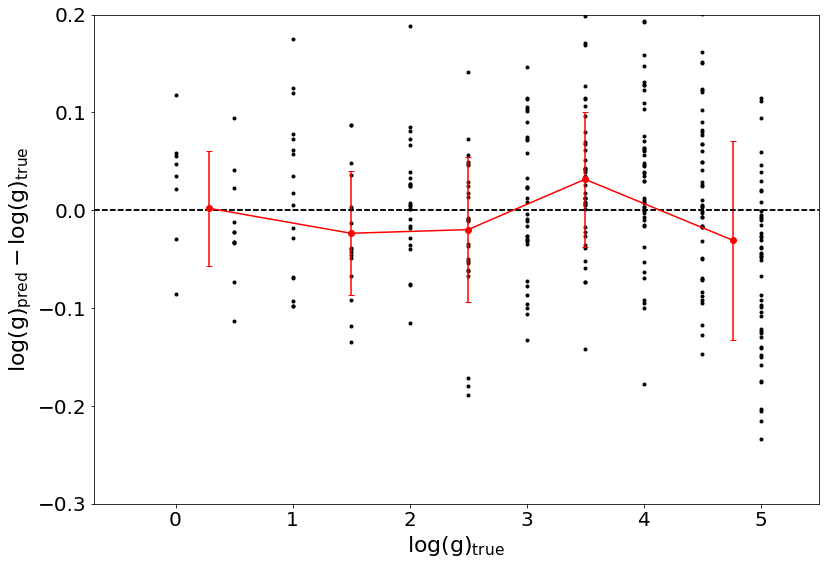

In [150]:
#Plot log 
plt.figure(figsize=(13,9))
# plot the difference
plt.scatter(logg_true, logg_diff ,c='k', marker='.')
#plt.plot(teff_true, teff_diff,'o', markersize=1, c='k')

# plot mean (symbol) and scatter with error bars
plt.errorbar(loggbin_mean,logg_diff_mean, yerr=logg_diff_std, fmt='-o', c='r',capsize=3) #plotting the teff bin mean in x-axis and teff_diff in y-axis

# increase the x,y tick label size
plt.tick_params(labelsize=20) 

# set x, y label. 
#plt.xlabel(r"$T_{\rm eff,true}$ (K)", fontsize=18)
#plt.ylabel(r"$T_{\rm eff,pred}-T_{\rm eff,true}$ (K)", fontsize=18)

# set x, y lim plot range
xlim=np.array([-0.7, 5.5])
ylim=np.array([-0.3, 0.2])
plt.xlim(xlim[0],xlim[1]) #plotting the xlim
plt.ylim(ylim[0],ylim[1])

# draw y=0 line
xline = np.linspace(xlim[0], xlim[1],2 )
yline = np.zeros_like(xline)
plt.plot(xline,yline,linestyle='--',c='k')

# set x, y label. 
plt.xlabel(r"$\rm log(g)_{\rm true}$", fontsize=22)
plt.ylabel(r"$\rm log(g)_{\rm pred}-\rm log(g)_{\rm true}$", fontsize=22)



# draw y=0 line
xline = np.linspace(xlim[0],xlim[1], 2)
yline = np.zeros_like(xline)
plt.plot(xline,yline,linestyle='--',c='k')



# Cross Validation Set

len of y_train_stack= 326


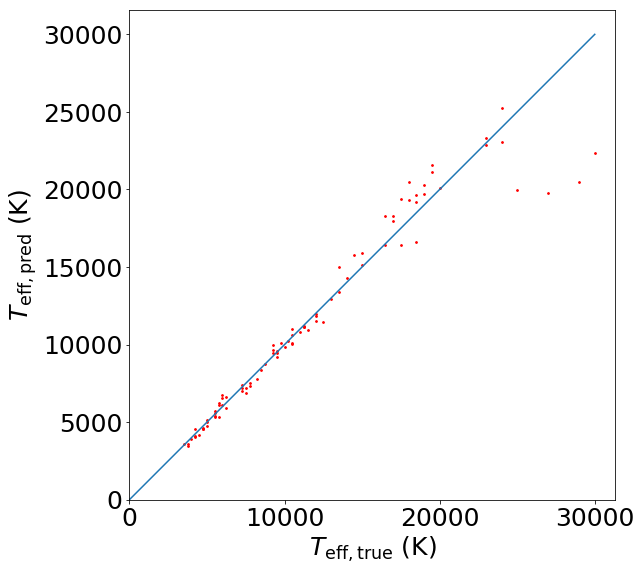

In [151]:
#Test set (x_cv)

test_predictions = model.predict(x_cv)
plt.figure(figsize=(13,9))
cv_predictions = model.predict(x_cv).flatten()
plt.scatter(denormalize(y_cv_stack[:,0], mean_teff, std_teff), denormalize(test_predictions[:,0], mean_teff, std_teff), c= 'r', s= 3, label= '$T_{eff}$')
plt.xlabel(r"$T_{\rm eff,true}$ (K)", fontsize=25)
plt.ylabel(r"$T_{\rm eff,pred}$ (K)", fontsize=25)
plt.axis('equal')
plt.axis('square')
# increase the x,y tick label size
plt.tick_params(labelsize=25) 
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([0, 30000], [0, 30000])

#print('test predictions=', test_predictions)

print('len of y_train_stack=',len(y_train_stack[:,0]))  



len of y_train_stack= 89


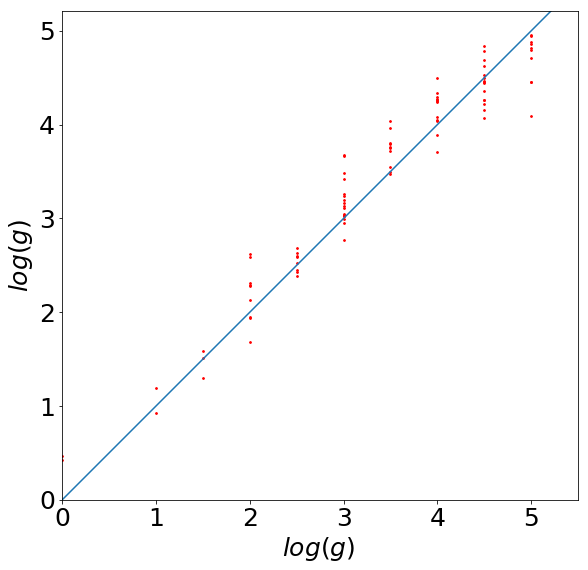

In [152]:
#Test set (x_cv)

test_predictions = model.predict(x_cv)
plt.figure(figsize=(13,9))
cv_predictions = model.predict(x_cv).flatten()
plt.scatter(denormalize(y_cv_stack[:,1], mean_logg, std_logg), denormalize(test_predictions[:,1], mean_logg, std_logg), c= 'r', s= 3, label= '$log(g)$')
plt.xlabel(r"$log(g)$ ", fontsize=25)
plt.ylabel(r"$log(g)$", fontsize=25)
plt.axis('equal')
plt.axis('square')
# increase the x,y tick label size
plt.tick_params(labelsize=25) 
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([0, 30000], [0, 30000])

#print('test predictions=', test_predictions)

print('len of y_train_stack=',len(y_cv_stack[:,0]))  



In [158]:
# getting deviation in Teff bins
teffbin_edges=np.array( [4000, 5000, 6000,  7000, 8000,  9000,  10000,  12000, 13000])
nbin = len(teffbin_edges)


# pred vs. true
# unnormalised values
teff_pred = denormalize(test_predictions[:,0], mean_teff, std_teff)
teff_true = denormalize(y_cv_stack[:,0], mean_teff, std_teff) #teff values are created by read_spectra1_updatedwavelength from the nsc Allende Prieto spectra library
teff_diff = teff_pred-teff_true

print(' Teff diff mean and std for Teff<11000=', np.mean(teff_diff[(teff_true>4000) & (teff_true<11000.0)]), 
      np.std(teff_diff[(teff_true>4000) & (teff_true<11000.0)]),
      len(teff_diff[(teff_true>4000) & (teff_true<11000.0)]))

# compute mean and std in Teff bins
teff_diff_mean = np.zeros(nbin) 
teff_diff_std = np.zeros(nbin)
teffbin_mean = np.zeros(nbin)

for i in range(nbin): #iterations(0,1,2,3,4)
    if i==0:
        indx = np.where(teff_true<teffbin_edges[i]) #index of teff_true where teff true< 5000 since teff has all values of teff in each library
        #print(indx)
    elif i==nbin-1: #if i= 5-1= 4
        indx = np.where(teff_true>teffbin_edges[i-1]) #index of true_teff>20000
    else: #if i=1,2,3
        indx = np.where((teff_true>teffbin_edges[i-1]) & (teff_true<teffbin_edges[i]))
        #if i=1, teff_true>(teffbin_edges[1-1=0]= 5000) & teff_true<teffbin_edges[1]= 10000, so 5000<teff<10000
        #if i=2, teff_true>(teffbin_edges[2-1=1]=10000) & teff_true<teffbin_edges[2]= 15000, so 10000<teff<15000
        #if i=3, teff_true> (teffbin_edges[3-1=2]= 15000) & teff_true<teffbin_edges[3]= 20000 so 15000<teff<20000
    teffbin_mean[i] = np.mean(teff_true[indx]) #calculating the mean values of teff_true from assigning its index in the for loop
    teff_diff_mean[i] = np.mean(teff_diff[indx]) #calculating the mean values of teff_diff from its index 
    teff_diff_std[i] = np.std(teff_diff[indx]) #calculating the std values of teff-diff from its index
    
print('mean of bin teff_true=', teffbin_mean)
print('mean of teff_diff=', teff_diff_mean)
print('std of teff_diff=', teff_diff_std)
print('length of teff_diff=', len(teff_diff))

####################################################################################################################
print('==========================================================================================================')
# getting deviation in Teff bins

loggbin_edges=np.array([   1, 2, 3, 4, 5, 6])
nbin = len(loggbin_edges)

# pred vs. true
# unnormalised values
logg_pred = denormalize(test_predictions[:,1], mean_logg, std_logg)
logg_true = denormalize(y_cv_stack[:,1], mean_logg, std_logg) #teff values are created by read_spectra1_updatedwavelength from the nsc Allende Prieto spectra library
logg_diff = logg_pred-logg_true

print(' logg diff mean and std for logg<5=', np.mean(logg_diff[(logg_true >2) & (logg_true<5)]),
       np.std(logg_diff[(logg_true>2) & (logg_true<5)]),
      len(logg_diff[(logg_true>2) & (logg_true<5)]))

# compute mean and std in Teff bins
logg_diff_mean = np.zeros(nbin) 
logg_diff_std = np.zeros(nbin)
loggbin_mean = np.zeros(nbin)

for i in range(nbin): #iterations(0,1,2,3,4)
    if i==0:
        indx = np.where(logg_true<loggbin_edges[i]) #index of teff_true where teff true< 5000 since teff has all values of teff in each library
        #print(indx)
    elif i==nbin-1: #if i= 5-1= 4
        indx = np.where(logg_true>loggbin_edges[i-1]) #index of true_teff>20000
    else: #if i=1,2,3
        indx = np.where((logg_true>loggbin_edges[i-1]) & (logg_true<loggbin_edges[i]))

    loggbin_mean[i] = np.mean(logg_true[indx]) #calculating the mean values of teff_true from assigning its index in the for loop
    logg_diff_mean[i] = np.mean(logg_diff[indx]) #calculating the mean values of teff_diff from its index 
    logg_diff_std[i] = np.std(logg_diff[indx]) #calculating the std values of teff-diff from its index
    
print('mean of bin logg_true=', loggbin_mean)
print('mean of logg_diff=', logg_diff_mean)
print('std of logg_diff=', logg_diff_std)
print('length of logg_diff=', len(logg_diff))







        

 Teff diff mean and std for Teff<11000= -9.193240017361111 324.27458952157644 45
mean of bin teff_true= [ 3666.66666667  4500.          5607.14285714  6250.
  7464.28571429  8500.          9428.57142857 10850.
 18953.125     ]
mean of teff_diff= [-118.22021484 -116.85351562   57.40262277   -5.72363281 -240.35205078
 -198.22102865  201.05538504 -134.74970703 -336.24597168]
std of teff_diff= [ 164.55253277  193.10341919  292.12947651  361.92285156  227.90647511
  180.16359208  294.11832456  285.73298056 2768.52956593]
length of teff_diff= 89
 logg diff mean and std for logg<5= 0.11153549148190406 0.2333999069724612 62
mean of bin logg_true= [-4.4408921e-16  1.5000000e+00  2.5000000e+00  3.5000000e+00
  4.5000000e+00            nan]
mean of logg_diff= [ 0.20806026 -0.03619285  0.03600654  0.23549185 -0.05634982         nan]
std of logg_diff= [0.33959138 0.12337011 0.09896223 0.17690421 0.21901607        nan]
length of logg_diff= 89


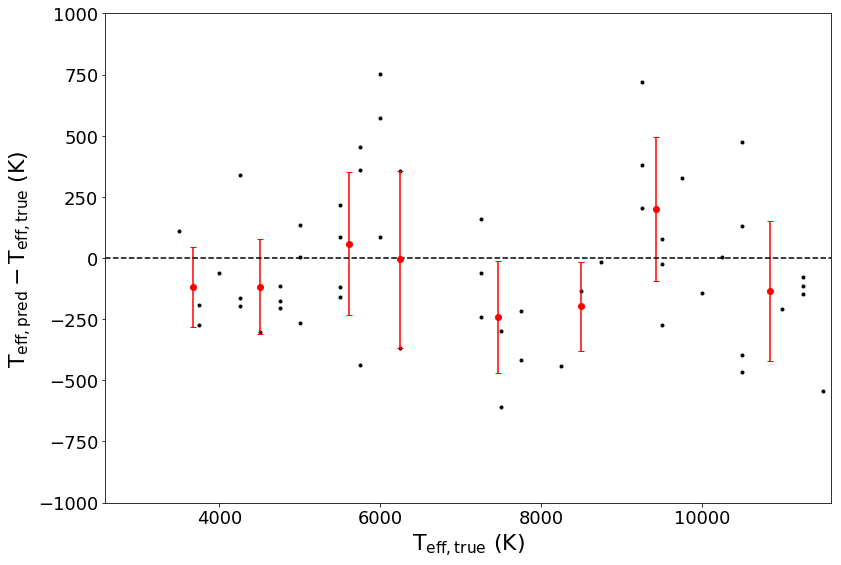

In [156]:
# plot
plt.figure(figsize=(13,9))
# plot the difference
plt.scatter(teff_true, teff_diff ,c='k', marker='.')
#plt.plot(teff_true, teff_diff,'o', markersize=1, c='k')

# plot mean (symbol) and scatter with error bars
plt.errorbar(teffbin_mean,teff_diff_mean, yerr=teff_diff_std, fmt='o', c='r',capsize=3) #plotting the teff bin mean in x-axis and teff_diff in y-axis

# increase the x,y tick label size
plt.tick_params(labelsize=18) 

# set x, y label. 
plt.xlabel(r"$T_{\rm eff,true}$ (K)", fontsize=22)
plt.ylabel(r"$T_{\rm eff,pred}-T_{\rm eff,true}$ (K)", fontsize=22)


# set x, y lim plot range
xlim=np.array([2580,11600])
ylim=np.array([-1000, 1000])
plt.xlim(xlim[0],xlim[1]) #plotting the xlim
plt.ylim(ylim[0],ylim[1])

# set x, y label. 
plt.xlabel(r"$\rm T_{\rm eff,true}$ (K)", fontsize=22)
plt.ylabel(r"$\rm T_{\rm eff,pred}-\rm T_{\rm eff,true}$ (K)", fontsize=22)

# draw y=0 line
xline = np.linspace(xlim[0],xlim[1], 2)
yline = np.zeros_like(xline)
plt.plot(xline,yline,linestyle='--',c='k')






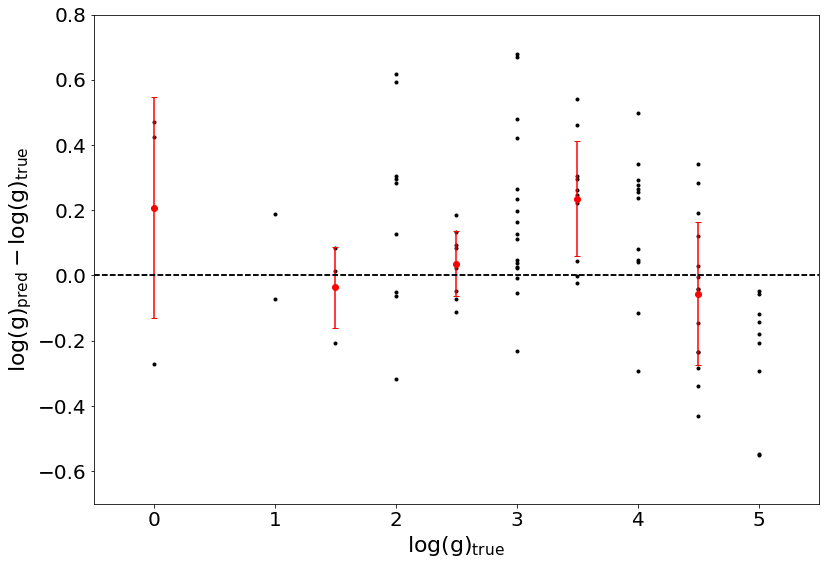

In [157]:
#Plot log 
plt.figure(figsize=(13,9))
# plot the difference
plt.scatter(logg_true, logg_diff ,c='k', marker='.')
#plt.plot(teff_true, teff_diff,'o', markersize=1, c='k')

# plot mean (symbol) and scatter with error bars
plt.errorbar(loggbin_mean,logg_diff_mean, yerr=logg_diff_std, fmt='o', c='r',capsize=3) #plotting the teff bin mean in x-axis and teff_diff in y-axis

# increase the x,y tick label size
plt.tick_params(labelsize=20) 

# set x, y label. 
#plt.xlabel(r"$T_{\rm eff,true}$ (K)", fontsize=18)
#plt.ylabel(r"$T_{\rm eff,pred}-T_{\rm eff,true}$ (K)", fontsize=18)

# set x, y lim plot range
xlim=np.array([-0.5, 5.5])
ylim=np.array([-0.7, 0.8])
plt.xlim(xlim[0],xlim[1]) #plotting the xlim
plt.ylim(ylim[0],ylim[1])

# draw y=0 line
xline = np.linspace(xlim[0], xlim[1],2 )
yline = np.zeros_like(xline)
plt.plot(xline,yline,linestyle='--',c='k')

# set x, y label. 
plt.xlabel(r"$\rm log(g)_{\rm true}$", fontsize=22)
plt.ylabel(r"$\rm log(g)_{\rm pred}-\rm log(g)_{\rm true}$", fontsize=22)



# draw y=0 line
xline = np.linspace(xlim[0],xlim[1], 2)
yline = np.zeros_like(xline)
plt.plot(xline,yline,linestyle='--',c='k')



In [99]:
# Input spectra
input_spec = Input(shape=(num_fluxes,), name='starnet_input_x')

# Reshape spectra for CNN layers
cur_in = Reshape((num_fluxes, 1))(input_spec)

# CNN layers
# First
cur_in = Conv1D(kernel_initializer=initializer, activation=activation, 
                padding="same", filters=128, kernel_size=32)(cur_in) #first CNN layer
# Max pooling layer
cur_in = MaxPooling1D(pool_size=32)(cur_in)
# Second CNN layer
cur_in = Conv1D(kernel_initializer=initializer, activation=activation,
                padding="same", filters=128, kernel_size=16)(cur_in) #2nd CNN layer
# Max pooling layer
cur_in = MaxPooling1D(pool_size=16)(cur_in)
# Third CNN layer
cur_in = Conv1D(kernel_initializer=initializer, activation=activation,
                padding="same", filters=128, kernel_size=8)(cur_in) #2nd CNN layer
# Max pooling layer
cur_in = MaxPooling1D(pool_size=8)(cur_in)

# Flatten the current input for the fully-connected layers
cur_in = Flatten()(cur_in)

# Fully-connected layers
cur_in = Dense(units=258, kernel_initializer=initializer, 
               activation=activation)(cur_in)
cur_in = Dense(units=128, kernel_initializer=initializer, 
               activation=activation)(cur_in)

# Output nodes
output_label = Dense(units=num_labels, kernel_regularizer=keras.regularizers.l2(0.01), activation="linear", 
                     input_dim=num_hidden[1])(cur_in)

model = Model(input_spec, output_label)

ValueError: Negative dimension size caused by subtracting 8 from 1 for 'max_pooling1d_12/MaxPool' (op: 'MaxPool') with input shapes: [?,1,1,128].

In [16]:
optimizer = Adam(lr=0.0005)

In [97]:
# loss function to minimize
loss_function = 'mean_squared_error'
optimizer = 'adadelta'
# compute mean absolute deviation
metrics = ['mae', 'mse']
#metrics = ['mae']
model.compile(optimizer=optimizer, loss=loss_function, metrics=metrics)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
starnet_input_x (InputLayer) (None, 6758)              0         
_________________________________________________________________
reshape_10 (Reshape)         (None, 6758, 1)           0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 6758, 128)         4224      
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 211, 128)          0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 211, 128)          262272    
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 13, 128)           0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 13, 128)           131200    
__________

In [ ]:
history = model.fit(x_train, y_train, 
          epochs=max_epochs, validation_split = 0.2, verbose=1, shuffle='batch')

Train on 875 samples, validate on 219 samples
Epoch 1/200
875/875 [==============================] - 13s 15ms/step - loss: 5.2174 - mean_absolute_error: 1.4147 - mean_squared_error: 5.1988 - val_loss: 1.5482 - val_mean_absolute_error: 0.9417 - val_mean_squared_error: 1.5305
Epoch 2/200
875/875 [==============================] - 12s 14ms/step - loss: 0.3955 - mean_absolute_error: 0.5094 - mean_squared_error: 0.3783 - val_loss: 1.8217 - val_mean_absolute_error: 1.0313 - val_mean_squared_error: 1.8050
Epoch 3/200
875/875 [==============================] - 12s 14ms/step - loss: 0.3606 - mean_absolute_error: 0.4579 - mean_squared_error: 0.3443 - val_loss: 1.9750 - val_mean_absolute_error: 1.0742 - val_mean_squared_error: 1.9589
Epoch 4/200
875/875 [==============================] - 12s 14ms/step - loss: 0.3806 - mean_absolute_error: 0.4960 - mean_squared_error: 0.3648 - val_loss: 2.0388 - val_mean_absolute_error: 1.0894 - val_mean_squared_error: 2.0232
Epoch 5/200
875/875 [=================

Epoch 72/200
875/875 [==============================] - 12s 14ms/step - loss: 0.0399 - mean_absolute_error: 0.1346 - mean_squared_error: 0.0361 - val_loss: 1.6221 - val_mean_absolute_error: 0.9613 - val_mean_squared_error: 1.6183
Epoch 73/200
875/875 [==============================] - 13s 14ms/step - loss: 0.0413 - mean_absolute_error: 0.1380 - mean_squared_error: 0.0375 - val_loss: 1.5695 - val_mean_absolute_error: 0.9410 - val_mean_squared_error: 1.5657
Epoch 74/200
875/875 [==============================] - 12s 14ms/step - loss: 0.0508 - mean_absolute_error: 0.1554 - mean_squared_error: 0.0470 - val_loss: 1.6579 - val_mean_absolute_error: 0.9698 - val_mean_squared_error: 1.6541
Epoch 75/200
875/875 [==============================] - 12s 14ms/step - loss: 0.0419 - mean_absolute_error: 0.1415 - mean_squared_error: 0.0381 - val_loss: 1.9499 - val_mean_absolute_error: 1.0596 - val_mean_squared_error: 1.9461
Epoch 76/200
875/875 [==============================] - 12s 14ms/step - loss: 0.

875/875 [==============================] - 12s 13ms/step - loss: 0.0267 - mean_absolute_error: 0.1066 - mean_squared_error: 0.0241 - val_loss: 1.3541 - val_mean_absolute_error: 0.8321 - val_mean_squared_error: 1.3514
Epoch 143/200
875/875 [==============================] - 13s 14ms/step - loss: 0.0540 - mean_absolute_error: 0.1430 - mean_squared_error: 0.0514 - val_loss: 1.8749 - val_mean_absolute_error: 1.0292 - val_mean_squared_error: 1.8723
Epoch 144/200
875/875 [==============================] - 12s 14ms/step - loss: 0.0324 - mean_absolute_error: 0.1221 - mean_squared_error: 0.0298 - val_loss: 1.3159 - val_mean_absolute_error: 0.8185 - val_mean_squared_error: 1.3133
Epoch 145/200
875/875 [==============================] - 12s 14ms/step - loss: 0.0255 - mean_absolute_error: 0.0968 - mean_squared_error: 0.0230 - val_loss: 1.3150 - val_mean_absolute_error: 0.8193 - val_mean_squared_error: 1.3124
Epoch 146/200
875/875 [==============================] - 12s 14ms/step - loss: 0.0254 - me

In [32]:
hist = pd.DataFrame(history.history)
hist['epoch']= history.epoch
hist.tail()

,val_loss,val_mean_absolute_error,val_mean_squared_error,loss,mean_absolute_error,mean_squared_error,epoch
195,6.650632e+07,6355.818481,6.650632e+07,1.702399e+06,881.769361,1.702399e+06,195
196,6.275853e+07,6161.197162,6.275853e+07,1.711892e+06,930.596856,1.711892e+06,196
197,5.944006e+07,5997.135702,5.944006e+07,1.580298e+06,893.164042,1.580298e+06,197
198,6.229281e+07,6138.579988,6.229281e+07,1.912179e+06,979.157146,1.912179e+06,198
199,6.106594e+07,6076.085226,6.106594e+07,1.614590e+06,912.569914,1.614590e+06,199


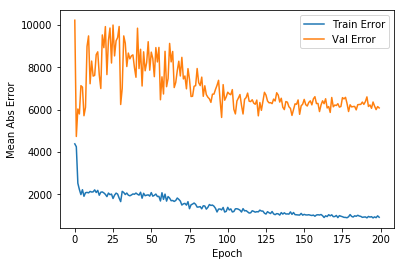

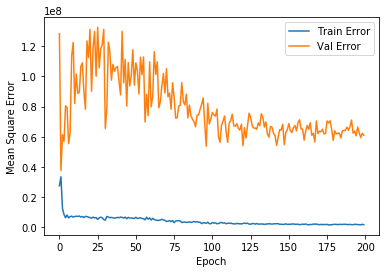

In [33]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  #plt.ylim([0,5])
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  #plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

test predictions= [ 6836.807   6837.5747  6836.7603 ... 10159.98   12968.633  12631.623 ]


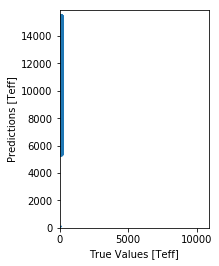

In [34]:
test_predictions = model.predict(norm_flux).flatten()

plt.scatter(normalize(teff), test_predictions)
plt.xlabel('True Values [Teff]')
plt.ylabel('Predictions [Teff]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

print('test predictions=', test_predictions)